In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = "https://raw.githubusercontent.com/mlguy001/gitTest/main/corporate_rating.csv"
df = pd.read_csv(path)

In [ ]:
rank = {'D':0,'C':1,'CC':2,'CCC':3,'B':4,'BB':5,'BBB':6,'A':7,'AA':8,'AAA':9}
order = pd.DataFrame()
order["Rank"] = rank.values()
order.index = rank.keys()
order = pd.merge(order, df["Rating"].value_counts().rename("Frequency"), left_index=True, right_index=True, how="left")
order["Frequency"] = order["Frequency"].cumsum()

In [ ]:
orderType = "Rank"
orderType = "Frequency"
df["Score"] = df["Rating"].map(order[orderType])

**Distributions**

In [ ]:
col1 = "Sector"
col2 = "Rating Agency Name"
table = pd.pivot_table(df[[col1, col2]], index=[col1],
                       columns=[col2], aggfunc=len, fill_value=0)
sns.heatmap(table)

In [ ]:
sns.catplot(x="Rating", kind="count", palette="ch:.25", data=df, order=rank)

In [ ]:
col = col2
dist = df.groupby([col, "Rating"]).agg({
    col : lambda x:x.count()/df[df[col]==x.iloc[0]][col2].count()
})
dist = dist.rename(columns={col:"Rate"})
dist.reset_index(inplace=True)

l = dist[col].unique()
N = len(l)
fig, axes = plt.subplots(nrows=N, sharex=True, figsize=(5, N*2.5))
fig.suptitle(f"Distributions per {col}")
for i in range(N):
  data = dist[dist[col]==l[i]]
  sns.barplot(ax=axes[i], y="Rate", x="Rating", order=rank, data=data)
  if i!= N-1:
    axes[i].axes.get_xaxis().set_visible(False)
  axes[i].set_title(l[i])

**Linear relationships**

In [ ]:
for col in df.describe().columns:
  sup = df[col].quantile(0.99)
  inf = df[col].quantile(0.01)
  data = df[(inf<=df[col]) & (df[col]<=sup)]
  data = data[["Score", col]]
  data.plot.scatter(x=col, y="Score")

**Outlier handling**

In [ ]:
for col in df.describe().columns:
  sup = df[col].quantile(0.99)
  inf = df[col].quantile(0.01)
  df[col] = df[col].apply(lambda x:max(x,inf))
  df[col] = df[col].apply(lambda x:min(x,sup))

**Feature selection**

In [ ]:
corr = df.corr()["Score"]
numericFeatures = list(corr[abs(corr) >= 0.05].index[:-1])
numericFeatures

['currentRatio',
 'cashRatio',
 'returnOnAssets',
 'returnOnCapitalEmployed',
 'returnOnEquity',
 'assetTurnover',
 'fixedAssetTurnover',
 'debtRatio',
 'freeCashFlowOperatingCashFlowRatio',
 'enterpriseValueMultiple',
 'payablesTurnover']

In [ ]:
numericFeatures = df.describe().columns[:-1]
numericFeatures

Index(['currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare',
       'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue',
       'enterpriseValueMultiple', 'operatingCashFlowPerShare',
       'operatingCashFlowSalesRatio', 'payablesTurnover'],
      dtype='object')

**Preprocessing**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
X_numeric = df[numericFeatures].values

scaler = MinMaxScaler(feature_range=(0, 1))
X_numeric = scaler.fit_transform(X_numeric)

categoricalFeatures = ["Rating Agency Name", "Sector"]
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(df[categoricalFeatures]).toarray()

X = np.hstack([X_numeric, X_categorical])
Y = df["Rating"].values

**Imbalance handling - Oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversampler = RandomOverSampler()
X,Y = oversampler.fit_resample(X,Y)

X: (6710, 28)
Y: (6710,)


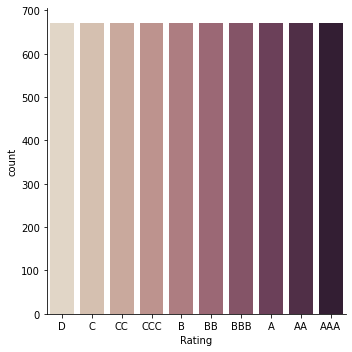

In [ ]:
print("X:", X.shape)
print("Y:", Y.shape)

data = pd.DataFrame({"Rating":Y})
sns.catplot(x="Rating", kind="count", palette="ch:.25", data=data, order=rank)

**Classifier**

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

model = RandomForestClassifier()

model.fit(X_train, Y_train)

RandomForestClassifier()

In [ ]:
predicted = model.predict(X_test)
print(f"Training accuracy score = {accuracy_score(Y_train, model.predict(X_train))}")
print(f"Test accuracy score = {accuracy_score(Y_test, predicted)}")

# print("Test Confusion matrix\n", confusion_matrix(Y_test, predicted))
print("Test Classification report\n", classification_report(Y_test, predicted))

Training accuracy score = 1.0
Test accuracy score = 0.9217585692995529
Test Classification report
               precision    recall  f1-score   support

           A       0.88      0.90      0.89       144
          AA       0.98      0.99      0.98       140
         AAA       1.00      1.00      1.00       129
           B       0.86      0.86      0.86       132
          BB       0.76      0.77      0.77       135
         BBB       0.74      0.70      0.72       131
           C       1.00      1.00      1.00       109
          CC       1.00      1.00      1.00       134
         CCC       0.99      1.00      0.99       144
           D       1.00      1.00      1.00       144

    accuracy                           0.92      1342
   macro avg       0.92      0.92      0.92      1342
weighted avg       0.92      0.92      0.92      1342



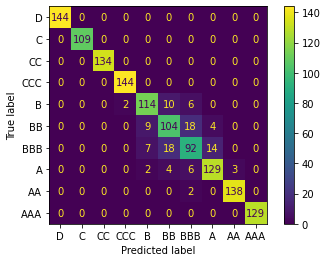

In [ ]:
# ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predicted, labels=list(rank.keys()))

**Neural Network**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Adagrad, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf

In [ ]:
y = pd.get_dummies(Y)
y = y[rank.keys()].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
def scheduler(epoch, lr):
  if epoch<100:
    return lr
  else:
    return lr*0.99

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X.shape[1], kernel_initializer=RandomNormal(stddev=1, seed=40)))
# model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_initializer=RandomNormal(stddev=1, seed=40)))
model.add(Dense(y.shape[1], activation='softmax'))

epochs = 300
learning_rate = 0.01
momentum = 0.1

optimizer = RMSprop(learning_rate=learning_rate, momentum=momentum)

loss = 'categorical_crossentropy'
loss = 'mean_squared_error'

model.compile(optimizer=optimizer,
              loss=loss,
              metrics="accuracy")

model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 16)                464       
                                                                 
 dense_69 (Dense)            (None, 8)                 136       
                                                                 
 dense_70 (Dense)            (None, 10)                90        
                                                                 
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs
                    , callbacks=[callback]
                    )
# history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.2, batch_size=50)

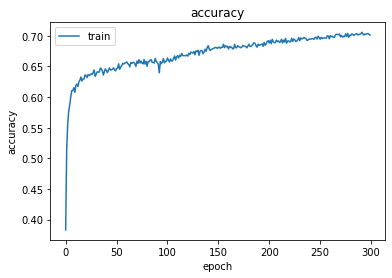

In [ ]:
metric = 'loss'
metric = 'accuracy'

plt.plot(history.history[metric])
# plt.plot(history.history[f"val_{metric}"])
plt.title(metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(["train", "test"], loc="upper left")

In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Evaluation score", scores)

predicted = model.predict(X_test)
testActual, testPredicted = np.argmax(Y_test, axis=1), np.argmax(predicted, axis=1)
trainActual, trainPredicted = np.argmax(Y_train, axis=1), np.argmax(model.predict(X_train), axis=1)

print(f"Training accuracy score = {accuracy_score(trainActual, trainPredicted)}")
print(f"Test accuracy score = {accuracy_score(testActual, testPredicted)}")

# print("Test Confusion matrix\n", confusion_matrix(testActual, testPredicted))
print("Test Classification report\n", classification_report(testActual, testPredicted))

Evaluation score [0.04181768000125885, 0.69076007604599]
Training accuracy score = 0.7075260804769001
Test accuracy score = 0.6907600596125186
Test Classification report
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       131
           1       0.96      1.00      0.98       133
           2       0.87      1.00      0.93       142
           3       0.66      0.63      0.64       146
           4       0.49      0.50      0.49       138
           5       0.41      0.32      0.36       128
           6       0.46      0.27      0.34       120
           7       0.41      0.23      0.30       133
           8       0.57      0.89      0.69       138
           9       0.84      1.00      0.91       133

    accuracy                           0.69      1342
   macro avg       0.66      0.68      0.66      1342
weighted avg       0.66      0.69      0.67      1342



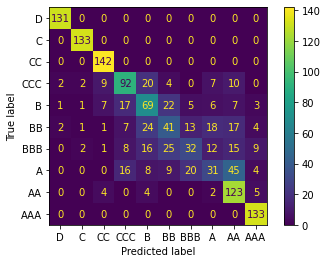

In [ ]:
ConfusionMatrixDisplay.from_predictions(testActual, testPredicted, display_labels=list(rank.keys()))

**Linear regression**

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import ElasticNet, BayesianRidge

In [ ]:
orderType = "Rank"
# orderType = "Frequency"
df["Score"] = df["Rating"].map(order[orderType])
order["Threshold"] = (order[orderType].shift(-1) + order[orderType])/2

Y_scores = np.vectorize(lambda x:order[orderType].loc[x])(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_scores, test_size=0.2, shuffle=True)

In [ ]:
ratings = list(order.index)
thresholds = list(order["Threshold"])
thresholds[-1] = np.Infinity
def decideRating(score):
  for r,t in zip(ratings, thresholds):
    res = r
    if not t:
      return ratings[-1]
    elif score < t:
      return res

In [ ]:
# model = ElasticNet(fit_intercept=False)
model = LinearRegression(fit_intercept=False)

model.fit(X_train, Y_train)

predicted = model.predict(X_test)
predictedLabels = np.vectorize(decideRating)(predicted)
reconstructedActualLabels = np.vectorize(decideRating)(Y_test)

predictedTrain = model.predict(X_train)
predictedTrainLabels = np.vectorize(decideRating)(predictedTrain)
reconstructedActualTrainLabels = np.vectorize(decideRating)(Y_train)

In [ ]:
print(f"Train Labels accuracy score = {accuracy_score(reconstructedActualTrainLabels, predictedTrainLabels)}")
print(f"Train Scores RMS = {np.sqrt(np.sum((Y_train-predictedTrain)))}")

print(f"Test Labels accuracy score = {accuracy_score(reconstructedActualLabels, predictedLabels)}")
print(f"Test Scores RMS = {np.sqrt(np.sum((Y_test-predicted)))}")

print("Test Classification report\n", classification_report(reconstructedActualLabels, predictedLabels))

Train Labels accuracy score = 0.1732488822652757
Train Scores RMS = nan
Test Labels accuracy score = 0.17436661698956782
Test Scores RMS = nan
Test Classification report
               precision    recall  f1-score   support

           A       0.19      0.33      0.24       128
          AA       0.16      0.12      0.14       136
         AAA       0.00      0.00      0.00       126
           B       0.22      0.27      0.24       142
          BB       0.19      0.28      0.23       130
         BBB       0.35      0.34      0.35       146
           C       0.00      0.00      0.00       141
          CC       0.19      0.37      0.25       105
         CCC       0.07      0.08      0.07       142
           D       0.00      0.00      0.00       146

    accuracy                           0.17      1342
   macro avg       0.14      0.18      0.15      1342
weighted avg       0.14      0.17      0.15      1342



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Train confusion matrix


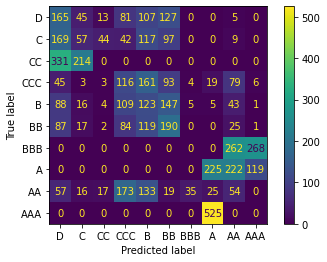

In [ ]:
print("Train confusion matrix")
ConfusionMatrixDisplay.from_predictions(reconstructedActualTrainLabels, predictedTrainLabels, display_labels=list(rank.keys()))

Test confusion matrix


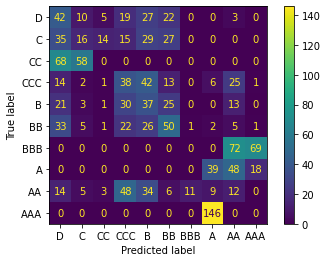

In [372]:
print("Test confusion matrix")
ConfusionMatrixDisplay.from_predictions(reconstructedActualLabels, predictedLabels, display_labels=list(rank.keys()))

In [373]:
model.coef_

array([   1.76375901,   -3.97081648, -164.52781664,  119.99304382,
        -57.32913384,  173.58140567, -175.15567598,   -7.59484207,
          6.88361396,    2.21865502,    1.06351568,   38.48973134,
         33.23825149,   32.68000999,   32.79135606,   32.32071247,
         13.84403748,   13.95958369,   14.19245581,   14.87504117,
         12.33020092,   12.19561315,   13.55741161,   14.3864692 ,
         14.51631205,   15.05070219,   15.73858959,   14.87364449])

In [374]:
model.intercept_

0.0